In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, jaccard_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-komputer-if3170/data_train.csv
/kaggle/input/data-komputer-if3170/data_validation.csv


# Setup

In [2]:
train_df = pd.read_csv("/kaggle/input/data-komputer-if3170/data_train.csv")
train_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,536,1,1.4,0,0,1,53,0.7,135,3,...,547,705,1211,15,10,7,1,0,1,0
1396,1097,0,0.8,0,10,1,21,0.1,160,7,...,1277,1352,2219,15,6,12,1,0,1,2
1397,1179,1,0.5,0,7,1,32,0.3,182,2,...,85,1451,340,16,5,16,1,0,0,0
1398,719,1,0.5,1,0,1,23,0.4,113,6,...,431,1727,3990,14,9,12,1,1,1,3


In [3]:
validation_df = pd.read_csv("/kaggle/input/data-komputer-if3170/data_validation.csv")
validation_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
2,769,1,2.9,1,0,0,9,0.1,182,5,...,248,874,3946,5,2,7,0,0,0,3
3,775,0,1.0,0,3,0,46,0.7,159,2,...,862,1864,568,17,15,11,1,1,1,0
4,595,0,0.9,1,7,1,23,0.1,121,3,...,441,810,3752,10,2,18,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1547,1,2.9,0,2,0,57,0.4,114,1,...,347,957,1620,9,2,19,0,1,1,1
596,1882,0,2.0,0,11,1,44,0.8,113,8,...,4,743,3579,19,8,20,1,1,0,3
597,674,1,2.9,1,1,0,21,0.2,198,3,...,576,1809,1180,6,3,4,1,1,1,0
598,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2


In [4]:
non_numeric_columns = ["blue", "wifi", "touch_screen", "three_g", "four_g", "dual_sim"]
drop_col = non_numeric_columns.copy()
drop_col.append("price_range")
numeric_columns = train_df.drop(drop_col, axis=1).columns.tolist()

# Data Preprocessing
Dari analisis EDA yang dilakukan akan dilakukan data preprocessing untuk melakukan pelatihan model

## Removing Outliers

Remove outliers using IQR

In [5]:
q3 = train_df['fc'].quantile(q=0.75)
q1 = train_df['fc'].quantile(q=0.25)
IQR = q3-q1
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

train_df = train_df[(train_df['fc'] >= lower_bound) &  (train_df['fc'] <= upper_bound)]
train_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,536,1,1.4,0,0,1,53,0.7,135,3,...,547,705,1211,15,10,7,1,0,1,0
1396,1097,0,0.8,0,10,1,21,0.1,160,7,...,1277,1352,2219,15,6,12,1,0,1,2
1397,1179,1,0.5,0,7,1,32,0.3,182,2,...,85,1451,340,16,5,16,1,0,0,0
1398,719,1,0.5,1,0,1,23,0.4,113,6,...,431,1727,3990,14,9,12,1,1,1,3


## Invalid Data Filling

Invalid data will be filled with median using interpolation

In [6]:
invalid_cleaning = train_df.copy()
median = invalid_cleaning['sc_w'].median()
invalid_cleaning['sc_w'].replace(0, median, inplace=True)

invalid_cleaned = invalid_cleaning.copy()

## Feature Selection
Remove fc column because it correlates the highest with pc

In [7]:
invalid_cleaned.drop(columns=['fc'], inplace=True)
invalid_cleaned

,battery_power,blue,clock_speed,dual_sim,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,1,41,0.9,89,1,13,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,1,11,0.6,139,5,16,68,1018,2826,18,5,2,1,0,0,2
2,1481,1,2.0,1,0,35,0.5,105,3,0,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,60,0.4,199,2,13,653,1413,1229,6,5,3,1,1,1,0
4,652,0,0.5,1,0,58,0.6,142,3,2,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,536,1,1.4,0,1,53,0.7,135,3,0,547,705,1211,15,10,7,1,0,1,0
1396,1097,0,0.8,0,1,21,0.1,160,7,15,1277,1352,2219,15,6,12,1,0,1,2
1397,1179,1,0.5,0,1,32,0.3,182,2,12,85,1451,340,16,5,16,1,0,0,0
1398,719,1,0.5,1,1,23,0.4,113,6,9,431,1727,3990,14,9,12,1,1,1,3


## Splitting Numeric and Non Numeric

In [8]:
numeric_columns.remove('fc')
non_numeric_columns.append('price_range')
train_numeric_df = invalid_cleaned[numeric_columns].copy()
train_non_numeric_df = invalid_cleaned[non_numeric_columns].copy()
index = invalid_cleaned.index

In [9]:
print(train_numeric_df.shape)
print(train_non_numeric_df.shape)

(1389, 13)
(1389, 7)


## Numeric Column Scaling

In [10]:
scaler = MinMaxScaler()
scaled_numeric = scaler.fit_transform(train_numeric_df)

scaled_df = pd.DataFrame(scaled_numeric, columns=numeric_columns, index = index)
scaled_df

,battery_power,clock_speed,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
0,0.202405,0.12,0.629032,0.888889,0.075000,0.000000,0.65,0.361735,0.212283,0.473276,0.428571,0.235294,0.500000
1,0.361389,0.68,0.145161,0.555556,0.491667,0.571429,0.80,0.034694,0.345794,0.686799,0.928571,0.235294,0.000000
2,0.654643,0.60,0.532258,0.444444,0.208333,0.285714,0.00,0.127041,0.014686,0.635756,0.857143,0.882353,0.111111
3,0.402806,0.48,0.935484,0.333333,0.991667,0.142857,0.65,0.333163,0.609479,0.260021,0.071429,0.235294,0.055556
4,0.100868,0.00,0.903226,0.555556,0.516667,0.285714,0.10,0.236735,0.187583,0.082576,0.928571,0.647059,0.388889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0.023380,0.36,0.822581,0.666667,0.458333,0.285714,0.00,0.279082,0.136849,0.255211,0.714286,0.529412,0.277778
1396,0.398130,0.12,0.306452,0.000000,0.666667,0.857143,0.75,0.651531,0.568758,0.524586,0.714286,0.294118,0.555556
1397,0.452906,0.00,0.483871,0.222222,0.850000,0.142857,0.60,0.043367,0.634846,0.022448,0.785714,0.235294,0.777778
1398,0.145625,0.00,0.338710,0.333333,0.275000,0.714286,0.45,0.219898,0.819092,0.997862,0.642857,0.470588,0.555556


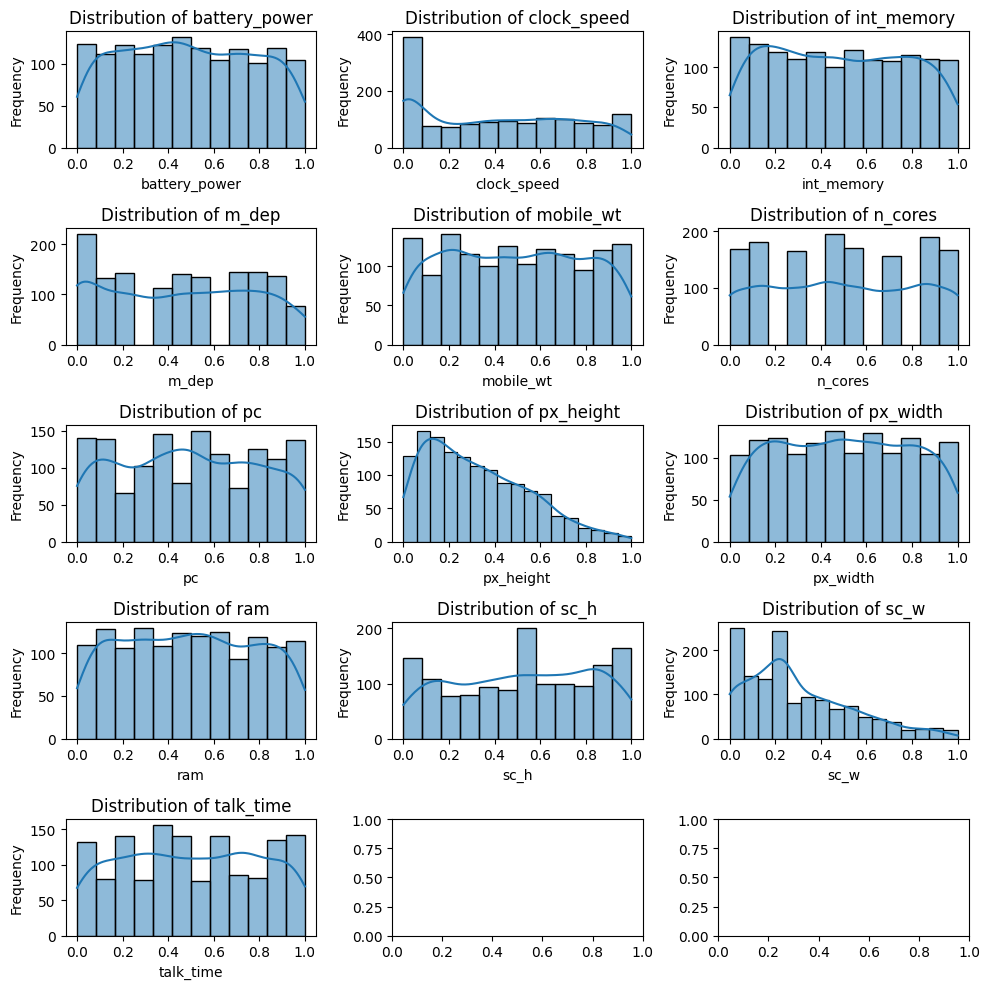

In [11]:
fig, ax = plt.subplots(5, 3, figsize = (10,10))
for i, col in enumerate(numeric_columns):
    r = i // 3
    c = i % 3
    
    sns.histplot(kde=True,data=scaled_df[col], ax=ax[r,c])    
    ax[r, c].set_title(f'Distribution of {col}')
    ax[r, c].set_xlabel(col)
    ax[r, c].set_ylabel("Frequency")
    
plt.tight_layout()
plt.show()

## Final Merging

In [12]:
processed_df = pd.concat([scaled_df, train_non_numeric_df], axis = 1)
processed_df

,battery_power,clock_speed,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,blue,wifi,touch_screen,three_g,four_g,dual_sim,price_range
0,0.202405,0.12,0.629032,0.888889,0.075000,0.000000,0.65,0.361735,0.212283,0.473276,0.428571,0.235294,0.500000,1,0,0,1,1,1,1
1,0.361389,0.68,0.145161,0.555556,0.491667,0.571429,0.80,0.034694,0.345794,0.686799,0.928571,0.235294,0.000000,0,0,0,1,1,0,2
2,0.654643,0.60,0.532258,0.444444,0.208333,0.285714,0.00,0.127041,0.014686,0.635756,0.857143,0.882353,0.111111,1,1,0,1,0,1,2
3,0.402806,0.48,0.935484,0.333333,0.991667,0.142857,0.65,0.333163,0.609479,0.260021,0.071429,0.235294,0.055556,0,1,1,1,1,0,0
4,0.100868,0.00,0.903226,0.555556,0.516667,0.285714,0.10,0.236735,0.187583,0.082576,0.928571,0.647059,0.388889,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0.023380,0.36,0.822581,0.666667,0.458333,0.285714,0.00,0.279082,0.136849,0.255211,0.714286,0.529412,0.277778,1,1,0,1,1,0,0
1396,0.398130,0.12,0.306452,0.000000,0.666667,0.857143,0.75,0.651531,0.568758,0.524586,0.714286,0.294118,0.555556,0,1,0,1,1,0,2
1397,0.452906,0.00,0.483871,0.222222,0.850000,0.142857,0.60,0.043367,0.634846,0.022448,0.785714,0.235294,0.777778,1,0,0,1,1,0,0
1398,0.145625,0.00,0.338710,0.333333,0.275000,0.714286,0.45,0.219898,0.819092,0.997862,0.642857,0.470588,0.555556,1,1,1,1,1,1,3


# Modelling

In [13]:
target_column = processed_df['price_range']
feature_column = processed_df.drop(columns=['price_range'])
feature_column

,battery_power,clock_speed,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,blue,wifi,touch_screen,three_g,four_g,dual_sim
0,0.202405,0.12,0.629032,0.888889,0.075000,0.000000,0.65,0.361735,0.212283,0.473276,0.428571,0.235294,0.500000,1,0,0,1,1,1
1,0.361389,0.68,0.145161,0.555556,0.491667,0.571429,0.80,0.034694,0.345794,0.686799,0.928571,0.235294,0.000000,0,0,0,1,1,0
2,0.654643,0.60,0.532258,0.444444,0.208333,0.285714,0.00,0.127041,0.014686,0.635756,0.857143,0.882353,0.111111,1,1,0,1,0,1
3,0.402806,0.48,0.935484,0.333333,0.991667,0.142857,0.65,0.333163,0.609479,0.260021,0.071429,0.235294,0.055556,0,1,1,1,1,0
4,0.100868,0.00,0.903226,0.555556,0.516667,0.285714,0.10,0.236735,0.187583,0.082576,0.928571,0.647059,0.388889,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0.023380,0.36,0.822581,0.666667,0.458333,0.285714,0.00,0.279082,0.136849,0.255211,0.714286,0.529412,0.277778,1,1,0,1,1,0
1396,0.398130,0.12,0.306452,0.000000,0.666667,0.857143,0.75,0.651531,0.568758,0.524586,0.714286,0.294118,0.555556,0,1,0,1,1,0
1397,0.452906,0.00,0.483871,0.222222,0.850000,0.142857,0.60,0.043367,0.634846,0.022448,0.785714,0.235294,0.777778,1,0,0,1,1,0
1398,0.145625,0.00,0.338710,0.333333,0.275000,0.714286,0.45,0.219898,0.819092,0.997862,0.642857,0.470588,0.555556,1,1,1,1,1,1


In [14]:
y_test = validation_df['price_range']
X_test = validation_df.drop(columns=["fc","price_range"])

# Reorder the columns
df1_columns = feature_column.columns
X_test = X_test.reindex(columns=df1_columns)

X_test

,battery_power,clock_speed,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,blue,wifi,touch_screen,three_g,four_g,dual_sim
0,842,2.2,7,0.6,188,2,2,20,756,2549,9,7,19,0,1,0,0,0,0
1,563,0.5,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,0,1,1,1,1
2,769,2.9,9,0.1,182,5,1,248,874,3946,5,2,7,1,0,0,0,0,1
3,775,1.0,46,0.7,159,2,16,862,1864,568,17,15,11,0,1,1,1,0,0
4,595,0.9,23,0.1,121,3,17,441,810,3752,10,2,18,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1547,2.9,57,0.4,114,1,3,347,957,1620,9,2,19,1,1,1,0,0,0
596,1882,2.0,44,0.8,113,8,19,4,743,3579,19,8,20,0,0,1,1,1,0
597,674,2.9,21,0.2,198,3,4,576,1809,1180,6,3,4,1,1,1,1,0,1
598,1965,2.6,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1,1,0,1


In [15]:
scaler = MinMaxScaler()
X_test_fix = scaler.fit_transform(X_test)
X_test_pd = pd.DataFrame(X_test_fix, columns=X_test.columns)
X_test_pd

,battery_power,clock_speed,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,blue,wifi,touch_screen,three_g,four_g,dual_sim
0,0.228246,0.68,0.080645,0.555556,0.900000,0.142857,0.10,0.010521,0.171237,0.613716,0.285714,0.388889,0.944444,0.0,1.0,0.0,0.0,0.0,0.0
1,0.041499,0.00,0.629032,0.888889,0.541667,0.571429,0.30,0.664387,0.813378,0.628181,0.428571,0.111111,0.388889,1.0,0.0,1.0,1.0,1.0,1.0
2,0.179384,0.96,0.112903,0.000000,0.850000,0.571429,0.05,0.130458,0.250167,0.987945,0.000000,0.111111,0.277778,1.0,0.0,0.0,0.0,0.0,1.0
3,0.183400,0.20,0.709677,0.666667,0.658333,0.142857,0.80,0.453446,0.912375,0.083043,0.857143,0.833333,0.500000,0.0,1.0,1.0,1.0,0.0,0.0
4,0.062918,0.16,0.338710,0.000000,0.341667,0.285714,0.85,0.231983,0.207358,0.935976,0.357143,0.111111,0.888889,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.700134,0.96,0.887097,0.333333,0.283333,0.000000,0.15,0.182536,0.305686,0.364854,0.285714,0.111111,0.944444,1.0,1.0,1.0,0.0,0.0,0.0
596,0.924364,0.60,0.677419,0.777778,0.275000,1.000000,0.95,0.002104,0.162542,0.889633,1.000000,0.444444,1.000000,0.0,0.0,1.0,1.0,1.0,0.0
597,0.115797,0.96,0.306452,0.111111,0.983333,0.285714,0.20,0.302998,0.875585,0.246986,0.071429,0.166667,0.111111,1.0,1.0,1.0,1.0,0.0,1.0
598,0.979920,0.84,0.596774,0.111111,0.891667,0.428571,0.15,0.481326,0.979933,0.475221,0.428571,0.555556,0.777778,1.0,1.0,1.0,1.0,0.0,1.0


## Using Scikit KNN

In [16]:
scikit_knn = KNeighborsClassifier(n_neighbors = 10)
scikit_knn.fit(feature_column, target_column)

KNeighborsClassifier(n_neighbors=10)

In [17]:
y_pred = scikit_knn.predict(X_test_pd)
y_pred

array([0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 3, 0, 3, 2, 3, 0, 3, 0, 0, 1, 3, 1,
       1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 3, 0, 1, 3, 1, 2, 1, 1, 0, 1, 0, 2,
       2, 2, 0, 3, 0, 3, 0, 1, 2, 1, 1, 2, 1, 3, 2, 2, 0, 3, 3, 0, 2, 0,
       3, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 3, 1, 2, 3, 1, 1, 1, 3, 2, 2, 3,
       1, 2, 0, 2, 2, 2, 1, 1, 3, 2, 0, 0, 3, 3, 0, 2, 3, 1, 3, 2, 1, 3,
       2, 1, 3, 2, 2, 0, 0, 3, 0, 2, 0, 2, 3, 3, 1, 0, 1, 0, 1, 3, 2, 1,
       1, 1, 3, 0, 0, 1, 3, 2, 1, 2, 3, 1, 1, 2, 2, 1, 0, 2, 3, 0, 2, 1,
       2, 0, 2, 2, 0, 1, 3, 2, 3, 2, 2, 2, 0, 1, 0, 3, 1, 3, 1, 0, 2, 3,
       2, 1, 3, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2, 0, 2, 3, 0, 0, 1, 2, 1, 1,
       2, 0, 0, 1, 2, 3, 1, 1, 2, 3, 0, 2, 1, 3, 2, 2, 0, 0, 1, 0, 0, 1,
       2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 3, 3, 1, 1, 3, 0, 0, 3, 3, 3, 1, 0,
       0, 1, 3, 3, 1, 2, 0, 1, 2, 0, 3, 0, 0, 3, 1, 0, 0, 1, 0, 2, 0, 3,
       3, 0, 2, 1, 3, 0, 1, 2, 0, 3, 0, 0, 3, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 2, 2, 2, 0, 3, 0, 1, 2, 3, 0, 3, 2,

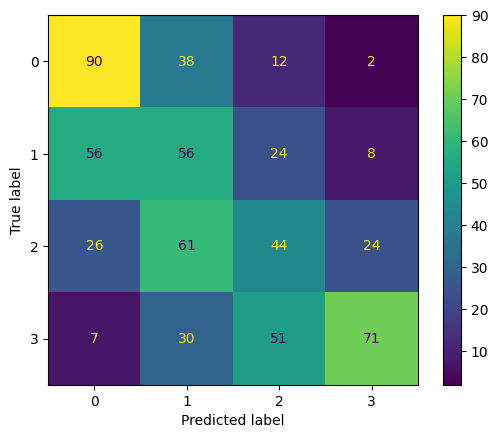

In [18]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

## Using Scikit Naive Bayes

In [19]:
scikit_nb = GaussianNB()
scikit_nb.fit(feature_column, target_column)

GaussianNB()

In [20]:
y_pred_nb = scikit_nb.predict(X_test_pd)
y_pred_nb

array([2, 2, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 0, 3, 0, 2, 1, 0, 2, 3, 1,
       0, 1, 1, 1, 2, 2, 0, 2, 2, 3, 3, 0, 2, 3, 2, 3, 1, 1, 0, 3, 0, 2,
       2, 1, 1, 2, 1, 3, 1, 2, 3, 0, 1, 3, 2, 3, 3, 2, 2, 3, 3, 1, 3, 2,
       2, 2, 2, 3, 2, 3, 1, 0, 1, 2, 0, 3, 1, 0, 3, 3, 0, 2, 3, 1, 3, 3,
       0, 2, 1, 1, 1, 2, 1, 1, 3, 2, 1, 3, 3, 3, 1, 2, 3, 2, 3, 2, 3, 3,
       3, 3, 2, 2, 3, 2, 0, 3, 1, 3, 1, 2, 2, 3, 3, 1, 2, 2, 1, 3, 3, 1,
       0, 0, 3, 0, 0, 1, 3, 0, 1, 3, 3, 1, 2, 3, 1, 2, 1, 2, 3, 1, 0, 2,
       1, 0, 2, 0, 0, 3, 3, 3, 0, 2, 3, 0, 1, 1, 0, 2, 3, 1, 1, 1, 1, 1,
       3, 0, 2, 0, 3, 1, 1, 2, 0, 2, 0, 3, 2, 0, 3, 2, 0, 1, 2, 0, 1, 3,
       3, 1, 2, 2, 2, 3, 2, 3, 3, 3, 0, 2, 0, 2, 3, 1, 2, 3, 2, 0, 0, 2,
       2, 2, 3, 3, 0, 2, 0, 3, 0, 2, 2, 2, 2, 1, 3, 0, 1, 3, 3, 3, 0, 0,
       1, 1, 3, 3, 2, 2, 0, 2, 1, 2, 2, 3, 0, 2, 2, 1, 1, 2, 0, 3, 2, 3,
       3, 0, 1, 3, 3, 0, 0, 2, 1, 1, 1, 0, 3, 2, 2, 2, 0, 1, 0, 1, 1, 1,
       0, 0, 3, 0, 3, 0, 1, 0, 1, 3, 2, 2, 0, 2, 1,

In [21]:
submit_nb_scikit =  pd.DataFrame(y_pred_nb, index=X_test.index, columns=["price_range"])
submit_nb_scikit

,price_range
0,2
1,2
2,3
3,0
4,3
...,...
595,1
596,3
597,0
598,1


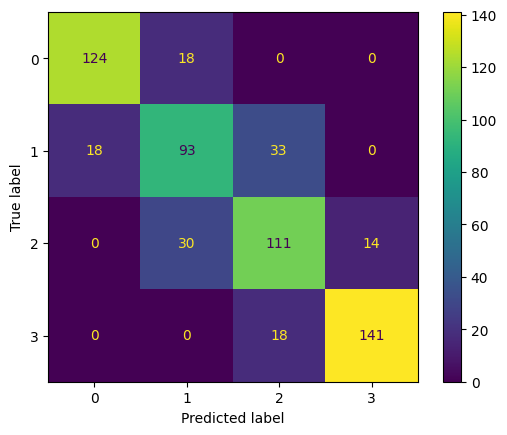

In [22]:
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Submission